https://ai.gopubby.com/you-dont-need-backpropagation-to-train-neural-networks-anymore-e989d75564cb

# get back to him, for more complext type models like unet

In [1]:
import torch

In [2]:
if torch.backends.mps.is_available():
    device = "mps"
elif torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

print("Using device:", device)

Using device: cuda


# Hyperparameters
# Loading MNIST
# Initializing model
# Begin training
Epoch 1/10  TrainAcc=96.43%  ValAcc=96.63%
Epoch 2/10  TrainAcc=98.23%  ValAcc=98.30%
Epoch 3/10  TrainAcc=98.55%  ValAcc=98.54%
Epoch 4/10  TrainAcc=97.74%  ValAcc=97.69%
Epoch 5/10  TrainAcc=98.84%  ValAcc=98.58%
Epoch 6/10  TrainAcc=99.20%  ValAcc=98.99%
Epoch 7/10  TrainAcc=99.15%  ValAcc=98.86%
Epoch 8/10  TrainAcc=99.32%  ValAcc=98.97%
Epoch 9/10  TrainAcc=99.36%  ValAcc=99.08%
Epoch 10/10  TrainAcc=99.24%  ValAcc=98.84%


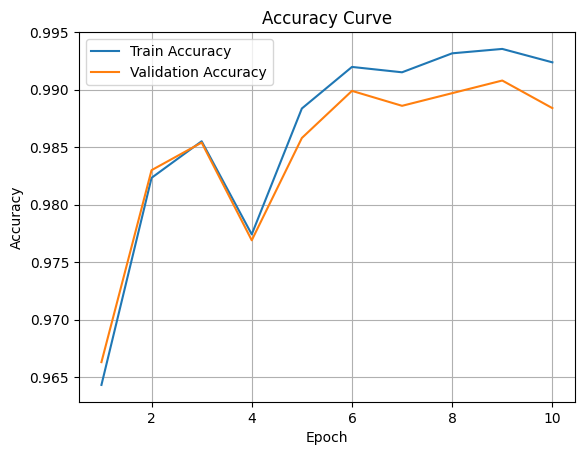


 Final Test Accuracy: 98.84%
# Class names for MNIST dataset
# Visualising predictions


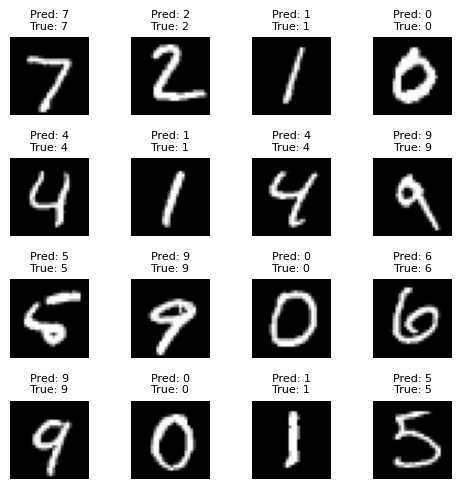

In [3]:
import torch
import torch.nn as nn
import math
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as transforms # Import the transforms module
import torchvision.datasets as datasets # Import the datasets module
from torch.utils.data import DataLoader # Import DataLoader

# Denoising block

class DenoiseBlock(nn.Module):
    def __init__(self, embedding_dim, num_classes):
        super().__init__()
        # Image path
        self.conv_path = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.2),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256)
        )

        # Noisy embedding path
        self.fc_z1 = nn.Linear(embedding_dim, 256)
        self.bn_z1 = nn.BatchNorm1d(256)

        self.fc_z2 = nn.Linear(256, 256)
        self.bn_z2 = nn.BatchNorm1d(256)

        self.fc_z3 = nn.Linear(256, 256)
        self.bn_z3 = nn.BatchNorm1d(256)

        # Combined downstream path
        self.fc_f1 = nn.Linear(256 + 256, 256)
        self.bn_f1 = nn.BatchNorm1d(256)
        self.fc_f2 = nn.Linear(256, 128)
        self.bn_f2 = nn.BatchNorm1d(128)
        self.fc_out = nn.Linear(128, num_classes)

    def forward(self, x, z_prev, W_embed):
        # Image features
        x_feat = self.conv_path(x)

        # Features from noisy embedding
        h1 = F.relu(self.bn_z1(self.fc_z1(z_prev)))
        h2 = F.relu(self.bn_z2(self.fc_z2(h1)))
        h3 = self.bn_z3(self.fc_z3(h2))

        z_feat = h3 + h1 # Residual connection

        # Combine and predict logits
        h_f = torch.cat([x_feat, z_feat], dim=1)
        h_f = F.relu(self.bn_f1(self.fc_f1(h_f)))
        h_f = F.relu(self.bn_f2(self.fc_f2(h_f)))
        logits = self.fc_out(h_f)

        # Softmax on logits
        p = F.softmax(logits, dim=1)
        z_next = p @ W_embed

        return z_next, logits


# NoProp-DT model

class NoPropDT(nn.Module):
    def __init__(self, num_classes, embedding_dim, T, eta):
        super().__init__()
        self.num_classes = num_classes
        self.embedding_dim = embedding_dim
        self.T = T
        self.eta = eta

        # Stacking up the Denoise blocks
        self.blocks = nn.ModuleList([
            DenoiseBlock(embedding_dim, num_classes) for _ in range(T)
        ])

        # Class-embedding matrix (W_embed)
        self.W_embed = nn.Parameter(torch.randn(num_classes, embedding_dim) * 0.1)

        # Classification head
        self.classifier = nn.Linear(embedding_dim, num_classes)

        # Cosine noise schedule
        t = torch.arange(1, T+1, dtype=torch.float32)
        alpha_t = torch.cos(t / T * (math.pi/2))**2
        alpha_bar = torch.cumprod(alpha_t, dim=0)
        snr = alpha_bar / (1 - alpha_bar)
        snr_prev = torch.cat([torch.tensor([0.], dtype=snr.dtype), snr[:-1]], dim=0)
        snr_diff = snr - snr_prev

        self.register_buffer('alpha_bar', alpha_bar)
        self.register_buffer('snr_diff', snr_diff)

    def forward_denoise(self, x, z_prev, t):
        return self.blocks[t](x, z_prev, self.W_embed)[0]

    def classify(self, z):
        return self.classifier(z)

    def inference(self, x):
        B = x.size(0)
        z = torch.randn(B, self.embedding_dim, device=x.device)

        for t in range(self.T):
            z = self.forward_denoise(x, z, t)

        return self.classify(z)

# Function for training NoProp-DT

def train_nopropdt(model, train_loader, test_loader, epochs, lr, weight_decay):
    # Using AdamW optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Dict to store metrics
    history = {'train_acc': [], 'val_acc': []}

    for epoch in range(1, epochs + 1):
        model.train()

        for t in range(model.T):
            for x, y in train_loader:
                x, y = x.to(device), y.to(device)
                uy = model.W_embed[y]
                alpha_bar_t = model.alpha_bar[t]
                noise = torch.randn_like(uy)
                z_t = torch.sqrt(alpha_bar_t) * uy + torch.sqrt(1 - alpha_bar_t) * noise

                z_pred, _ = model.blocks[t](x, z_t, model.W_embed)
                loss_l2 = F.mse_loss(z_pred, uy)
                loss = 0.5 * model.eta * model.snr_diff[t] * loss_l2

                if t == model.T - 1:
                    logits = model.classifier(z_pred)
                    loss_ce = F.cross_entropy(logits, y)
                    loss_kl = 0.5 * uy.pow(2).sum(dim=1).mean()
                    loss = loss + loss_ce + loss_kl

                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()

        # Training accuracy
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for x, y in train_loader:
                x, y = x.to(device), y.to(device)
                preds = model.inference(x).argmax(dim=1)
                correct += (preds == y).sum().item()
                total += y.size(0)

        train_acc = correct / total

        # Validation accuracy
        val_correct, val_total = 0, 0
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.to(device), y.to(device)
                preds = model.inference(x).argmax(dim=1)
                val_correct += (preds == y).sum().item()
                val_total += y.size(0)

        val_acc = val_correct / val_total

        # Storing accuracy history
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch}/{epochs}  "
              f"TrainAcc={100 * train_acc:.2f}%  ValAcc={100 * val_acc:.2f}%")

    # Plotting Training and Validation accuracy
    plt.figure()
    plt.plot(range(1, epochs + 1), history['train_acc'], label='Train Accuracy')
    plt.plot(range(1, epochs + 1), history['val_acc'], label='Validation Accuracy')
    plt.title("Accuracy Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"\n Final Test Accuracy: {100 * val_acc:.2f}%")

# Function to plot predictions

def show_predictions(model, test_loader, class_names=None, num_images = 16):
    model.eval()
    images_shown = 0
    plt.figure(figsize=(5, 5))

    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            logits = model.inference(x)
            preds = logits.argmax(dim=1)

            for i in range(x.size(0)):
                if images_shown >= num_images:
                    break

                plt.subplot(int(num_images**0.5), int(num_images**0.5), images_shown + 1)
                img = x[i].cpu().squeeze(0)
                plt.imshow(img, cmap='gray')
                actual = class_names[y[i]] if class_names else y[i].item()
                pred = class_names[preds[i]] if class_names else preds[i].item()
                plt.title(f"Pred: {pred}\nTrue: {actual}", fontsize=8)
                plt.axis('off')

                images_shown += 1

            if images_shown >= num_images:
                break

    plt.tight_layout()
    plt.show()


print('# Hyperparameters')

T = 10
eta = 0.1
embedding_dim = 512
batch_size = 128
lr = 1e-3
epochs = 10
weight_decay = 1e-3

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

print('# Loading MNIST')
transform = transforms.ToTensor()

train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_set  = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_set,  batch_size=batch_size)

print('# Initializing model')

model = NoPropDT(num_classes=10, embedding_dim=embedding_dim, T=T, eta=eta).to(device)

print('# Begin training')

train_nopropdt(model, train_loader, test_loader, epochs=epochs, lr=lr, weight_decay=weight_decay)


print('# Class names for MNIST dataset')
class_names = [str(i) for i in range(10)]

print('# Visualising predictions')
show_predictions(model, test_loader)

In [ ]:
# compare speed with the other method
# apply this to regression problem
# can we use unet, and more complex models?
# follow up with him ?